# Build neural networks with TensorFlow for collaborative filtering

In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten, Concatenate, Dense, Dropout
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

2023-06-25 11:29:12.168306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data preparation

In [2]:
df = pd.read_csv("small_rating.csv")

In [3]:
userIds = sorted(df["userId"].unique())
movieIds = sorted(df["movieId"].unique())

In [4]:
print("number of users: {}".format(len(userIds)))
print("number of movies: {}".format(len(movieIds)))

number of users: 500
number of movies: 200


In [5]:
print(userIds[:10])
print(movieIds[:10])

[156, 741, 768, 775, 903, 982, 1849, 2261, 2397, 3284]
[1, 2, 6, 10, 11, 16, 17, 19, 21, 25]


We need to map the users and movies to new IDs that are continuous integers starting from 0. This is to save the space.

In [6]:
df2 = df[["userId", "movieId", "rating"]].copy()
df2["userId"] = df2["userId"].map({v:k for k, v in enumerate(userIds)})
df2["movieId"] = df2["movieId"].map({v:k for k, v in enumerate(movieIds)})

In [7]:
N = df2.userId.max() + 1
M = df2.movieId.max() + 1

N: number of users  
M: number of movies

In [8]:
N, M

(500, 200)

shuffle the data before splitting into train and test sets.

In [9]:
df2 = shuffle(df2)

In [10]:
df2.head()

,userId,movieId,rating
69627,402,162,5.0
70071,405,98,5.0
40408,233,133,0.5
3843,22,0,4.0
41465,239,132,4.5


Split data into train dataset and test dataset.

In [11]:
cutoff = int(0.8 * len(df2))
df_train = df2.iloc[:cutoff]
df_test = df2.iloc[cutoff:]

In [12]:
df_train.shape, df_test.shape

((69212, 3), (17304, 3))

### A simple ANN for collaborative filtering  

The key for this architecture is the embedding of users and movies. Similar to word embedding in NLP, users and movies can be represented with vectors in the embedding space so that similar users and similar movies are close to each other. Embedding vectors can be considered as feature vectors, but they are learned during the training. After embedding users and movies, the two vectors are concatenated and followed with two fully connected layers to produce the predicted rating.

In [13]:

def build_model(N, M, K, reg=0.0):
    """
    Parameters:
        N: integer, number of users
        M: integer, number of movies
        K: integer, embedding dimension
        reg: float, l2 regularization
    Return:
        return a TensorFlow model
    """
    #userId, dimension is 1
    u = Input(shape=(1,))
    #movieId, dimension is 1
    m = Input(shape=(1,))
    u_embedding = Embedding(N, K, embeddings_regularizer=l2(reg))(u)
    m_embedding = Embedding(M, K, embeddings_regularizer=l2(reg))(m)
    # u_bias = Embedding(N, 1, embeddings_regularizer=l2(reg))(u)
    # m_bias = Embedding(M, 1, embeddings_regularizer=l2(reg))(m)
    # x = Dot(axes=2)([u_embedding, m_embedding])
    # x = Add()([x, u_bias, m_bias])
    # x= Flatten()(x)
    x = Concatenate(axis=-1)([u_embedding, m_embedding])
    x = Flatten()(x)
    x = Dense(500, activation='relu')(x)
    x = Dropout(0.5)(x)
    # x = Dense(16)(x)
    x = Dense(1)(x)
    model = Model(inputs = [u, m], outputs = x)
    return model


In [14]:
# K is embedding dimension
K = 10
# mu is the mean rating of the train dataset. use it to centeralize the data
mu = df_train.rating.mean()
epoch = 50
reg = 0.0

model = build_model(N, M, K, reg)
model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.005),
    metrics=['mse']
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 10)        5000        ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 10)        2000        ['input_2[0][0]']                
                                                                                              

2023-06-25 11:29:16.697523: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:

r = model.fit(
    x = [df_train.userId.values, df_train.movieId.values],
    y = df_train.rating.values - mu,
    epochs = epoch,
    batch_size=256,
    validation_data=(
        [df_test.userId.values, df_test.movieId.values],
        df_test.rating.values - mu
    )
)

Epoch 1/50


271/271 [==============================] - 1s 3ms/step - loss: 0.6993 - mse: 0.6993 - val_loss: 0.6437 - val_mse: 0.6437
Epoch 2/50
271/271 [==============================] - 1s 2ms/step - loss: 0.6410 - mse: 0.6410 - val_loss: 0.6206 - val_mse: 0.6206
Epoch 3/50
271/271 [==============================] - 1s 2ms/step - loss: 0.6261 - mse: 0.6261 - val_loss: 0.6136 - val_mse: 0.6136
Epoch 4/50
271/271 [==============================] - 1s 2ms/step - loss: 0.6154 - mse: 0.6154 - val_loss: 0.6064 - val_mse: 0.6064
Epoch 5/50
271/271 [==============================] - 1s 2ms/step - loss: 0.6100 - mse: 0.6100 - val_loss: 0.6132 - val_mse: 0.6132
Epoch 6/50
271/271 [==============================] - 1s 2ms/step - loss: 0.6044 - mse: 0.6044 - val_loss: 0.6135 - val_mse: 0.6135
Epoch 7/50
271/271 [==============================] - 1s 2ms/step - loss: 0.6004 - mse: 0.6004 - val_loss: 0.6044 - val_mse: 0.6044
Epoch 8/50
271/271 [==============================] - 1s 2ms/step - loss: 0.5975 - mse:

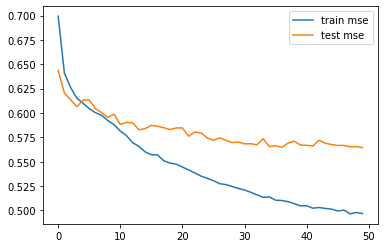

In [16]:
plt.plot(r.history['mse'], label="train mse")
plt.plot(r.history['val_mse'], label="test mse")
plt.legend()
plt.show()

### Use trained model to make prediction.

In [17]:
def one_user_all_movies(userId):
    userId_arr = np.array([userId] * M)
    movieId_arr = np.arange(M)
    return pd.DataFrame({"userId":userId_arr, "movieId":movieId_arr})

def predict_all_movies(model, userId):
    result_df = one_user_all_movies(userId)
    rating_pred = model.predict([result_df.userId.values, result_df.movieId.values])
    result_df['rating_pred'] = rating_pred + mu
    actual_df = df2.loc[df2["userId"]==userId, ["movieId", "rating"]]
    result_df = pd.merge(result_df, actual_df, how="left", on="movieId")
    return result_df

Predict the ratings of all movies for a specific user.

In [18]:
predict_all_df = predict_all_movies(model, 20)

7/7 [==============================] - 0s 895us/step


Compare predicted rating with actural rating of a specific user

This user rated 160 movies


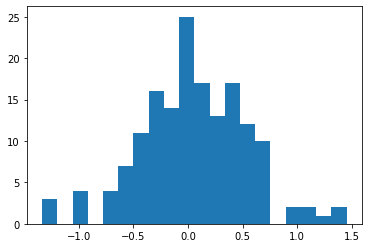

In [19]:
compare_df = predict_all_df[~predict_all_df["rating"].isna()].assign(residual=lambda df: df["rating_pred"] - df["rating"])
print("This user rated {} movies".format(compare_df.shape[0]))
plt.hist(compare_df['residual'], bins=20)
plt.show()

Most of the errors are within -1.0 and +1.0

Make recommendation from those not yet watched movies.

In [20]:
predict_all_df[predict_all_df["rating"].isna()].sort_values(by="rating_pred", ascending=False).head(10)

,userId,movieId,rating_pred,rating
147,20,147,3.865951,NaN
82,20,82,3.794595,NaN
93,20,93,3.694987,NaN
109,20,109,3.682422,NaN
172,20,172,3.660375,NaN
34,20,34,3.649328,NaN
105,20,105,3.632047,NaN
183,20,183,3.615762,NaN
83,20,83,3.614308,NaN
115,20,115,3.612540,NaN


### AutoRec: Autoencoders for collaborative filtering

ref: https://users.cecs.anu.edu.au/~u5098633/papers/www15.pdf  

We can store the movie ratings in a big matrix, whoes rows represent users and columns represent movies. Because a user usually only rate a very small portion of all the movies, this matrix is a sparse matrix with a lot of missing values. Autoencoder can reproduce the known input value and fill the missing value. During the training of this neural network, the input and output are the same, but noise is added into the input. Here, drop out is used as a way for adding noise.

In [21]:
from scipy.sparse import csr_matrix

Shuffle the dataset and split it into train and test dataset.

In [22]:
df2_shuffled = shuffle(df2)
cutoff = int(0.8 * len(df2))
train = df2_shuffled.iloc[:cutoff]
test = df2_shuffled.iloc[cutoff:]

mean_rating = train['rating'].mean()
print("the average rating of train dataset is {}".format(mean_rating))

# subtract mean from the train and test dataset. Need to add this to the predition values
train['rating'] = train['rating'] - mean_rating
test['rating'] = test['rating'] - mean_rating

the average rating of train dataset is 3.655782234294631


Convert the train and test dataset into sparse matrix.

In [23]:
N = df2.userId.max() + 1
M = df2.movieId.max() + 1
A = csr_matrix((train.rating, (train.userId, train.movieId)), shape=(N, M))
A_test = csr_matrix((test.rating, (test.userId, test.movieId)), shape=(N, M))

In [24]:
N, M

(500, 200)

When we calculate the loss, we only look at the values that are not 0, because 0 represents missing values. Here, mask is used to label which values are not 0.

In [25]:
mask = (A != 0) * 1.0
mask_test = (A_test != 0) * 1.0

We can not use the stardard MSE as loss function, because we only use the values that are not 0. A custom loss function is defined here. We also need to define custom data generator functions.

In [26]:
import keras.backend as K
from keras.utils import Sequence

In [27]:
def custom_loss(y_true, y_pred):
    # When we calculate the loss, we only look at the values that are not 0
    mask = K.cast(K.not_equal(y_true, 0), dtype='float32')
    diff = y_pred - y_true
    sqdiff = diff * diff * mask
    sse = K.sum(K.sum(sqdiff))
    n = K.sum(K.sum(mask))
    return sse / n


def generator(A, batch_size=256):
    batches = int(np.ceil(A.shape[0] / batch_size))
    while True: 
        A_shuf = shuffle(A) # shuffle the dataset for training
        for i in range(batches):
            a = A_shuf[i*batch_size:(i+1)*batch_size].toarray()
            # the input and output are the same for training.
            # I did not really add noise here, because dropout is used in the NN as a way for generating noise
            noisy = a
            # generate input and target output for training the NN. They are the same here
            yield noisy, a

def test_generator(A, A_test, batch_size=256):
    batches = int(np.ceil(A.shape[0] / batch_size))
    while True:
        for i in range(batches):
            a = A[i*batch_size:(i+1)*batch_size].toarray()
            at = A_test[i*batch_size:(i+1)*batch_size].toarray()
            # generate input and output data for testing the NN
            # this time, we use the train data (known values) to make prediction and then compare the prediction with test data
            yield a, at

# I can also use a custom data generator to feed the model
# define a custom data generator which inherits the keras.utils.Sequence class
class DataGenerator(Sequence):
    def __init__(self, train, test, batch_size = 256, is_train=True):
        """
        Parameters:
            train: sparse matrix with shape (N, M) where N is number of users and M is number of movies
            test: sparse matrix with shape (N, M)
        """
        self.train = train
        self.test = test
        self.batch_size = batch_size
        self.is_train = is_train
        self.n = train.shape[0]

    def __len__(self):
        return int(np.ceil(self.n / self.batch_size))
    
    def on_epoch_end(self):
        if self.is_train:
            self.train = shuffle(self.train)

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = min((idx+1) * self.batch_size, self.n)
        x_train = self.train[start:end].toarray()
        x_test = self.test[start:end].toarray()
        # noise = np.random.randn(*x_train.shape) * 0.5
        # mask = (x_train != 0)
        # x_train_noise = np.where(mask, x_train + noise, x_train)
        x_train_noise = x_train
        if self.is_train:
            # for training, the input and output are the same
            return x_train_noise, x_train
        else:
            # for testing, use the train data (known values) to make prediction and compare that to test data
            return x_train, x_test


In [28]:
for x, y in DataGenerator(A, A_test,5):
    print(x[:,10])
    print(y[:,10])
    break

[1.34421777 0.         1.34421777 0.34421777 0.34421777]
[1.34421777 0.         1.34421777 0.34421777 0.34421777]


Build the AutoRec model.

In [29]:
def autorec_model(M, dropout, n_hidden, reg):
    """
    Parameters:
        M: integer, input feature dimension, number of movies
        dropout: float, dropout rate for the input layer. It's a way to add noise
        n_hidden: integer, number of neurons in the hidden layer
        reg: float, l2 regularization
    Return:
        return the AutoRec model
    """
    i = Input(shape=(M,))
    x = Dropout(dropout)(i)
    x = Dense(n_hidden, activation='relu', kernel_regularizer=l2(reg))(x)
    outputs = Dense(M, kernel_regularizer=l2(reg))(x)

    model = Model(inputs = i, outputs = outputs)
    return model

compile the model. Use the custom loss function here.

In [30]:
model2 = autorec_model(M, dropout=0.70, n_hidden=100, reg=0.0005)
model2.compile(
    loss = custom_loss,
    optimizer=Adam(learning_rate=0.005),
    metrics=[custom_loss] 
)
model2.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200)]             0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               20100     
                                                                 
 dense_3 (Dense)             (None, 200)               20200     
                                                                 
Total params: 40,300
Trainable params: 40,300
Non-trainable params: 0
_________________________________________________________________


Train the model

In [31]:
batch_size=256
epochs = 50

# r2 = model2.fit(
#     generator(A, batch_size),
#     validation_data=test_generator(A, A_test, batch_size),
#     epochs=epochs,
#     steps_per_epoch=int(np.ceil(A.shape[0] / batch_size)),
#     validation_steps=int(np.ceil(A.shape[0] / batch_size))
# )

train_data_generator = DataGenerator(A, A_test, batch_size, is_train=True)
test_data_generator = DataGenerator(A, A_test, batch_size, is_train=False)
r2 = model2.fit(
    train_data_generator,
    validation_data = test_data_generator,
    epochs = epochs
)

Epoch 1/50


2/2 [==============================] - 1s 150ms/step - loss: 1.9108 - custom_loss: 1.7729 - val_loss: 1.1148 - val_custom_loss: 0.9871
Epoch 2/50
2/2 [==============================] - 0s 34ms/step - loss: 1.3899 - custom_loss: 1.2644 - val_loss: 1.0408 - val_custom_loss: 0.9192
Epoch 3/50
2/2 [==============================] - 0s 33ms/step - loss: 1.2219 - custom_loss: 1.1038 - val_loss: 1.0074 - val_custom_loss: 0.8914
Epoch 4/50
2/2 [==============================] - 0s 34ms/step - loss: 1.1209 - custom_loss: 1.0065 - val_loss: 0.9825 - val_custom_loss: 0.8718
Epoch 5/50
2/2 [==============================] - 0s 33ms/step - loss: 1.0413 - custom_loss: 0.9321 - val_loss: 0.9556 - val_custom_loss: 0.8496
Epoch 6/50
2/2 [==============================] - 0s 34ms/step - loss: 0.9811 - custom_loss: 0.8773 - val_loss: 0.9247 - val_custom_loss: 0.8228
Epoch 7/50
2/2 [==============================] - 0s 35ms/step - loss: 0.9272 - custom_loss: 0.8265 - val_loss: 0.8907 - val_custom_loss: 0.

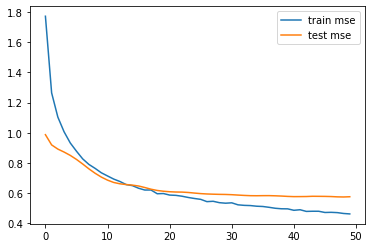

In [32]:
plt.plot(r2.history['custom_loss'], label="train mse")
plt.plot(r2.history['val_custom_loss'], label="test mse")
plt.legend()
plt.show()

### predict ratings of all movies for a specific user 

In [33]:
def autorec_input(userId):
    arr = np.zeros(M)
    user_df = df2[df2['userId']==userId]
    arr[user_df.movieId.values] = user_df.rating.values - mean_rating
    return np.expand_dims(arr, 0)

def autorec_rate_allmovies(model, userId):
    X = autorec_input(userId)
    pred = model.predict(X)[0]
    result_df = pd.DataFrame({
        "userId": userId,
        "movieId": np.arange(M),
        "autorec_rating": pred + mean_rating
    })
    actual_df = df2.loc[df2["userId"]==userId, ["movieId", "rating"]]
    result_df = pd.merge(result_df, actual_df, how="left", on="movieId")
    return result_df
    

In [34]:
autorec_rating_df = autorec_rate_allmovies(model2, 20)

1/1 [==============================] - 0s 43ms/step


In [35]:
compare_df = autorec_rating_df[~autorec_rating_df["rating"].isna()].assign(residual=lambda df: df['autorec_rating'] - df["rating"])
print("this user rated {} movies".format(compare_df.shape[0]))
compare_df

this user rated 160 movies


,userId,movieId,autorec_rating,rating,residual
0,20,0,3.465953,4.0,-0.534047
1,20,1,3.066041,3.0,0.066041
3,20,3,3.300404,4.0,-0.699596
4,20,4,3.163666,2.5,0.663666
5,20,5,3.287280,3.5,-0.212720
...,...,...,...,...,...
194,20,194,3.718714,3.0,0.718714
196,20,196,3.425693,3.0,0.425693
197,20,197,3.496594,3.5,-0.003406
198,20,198,3.703597,4.5,-0.796403


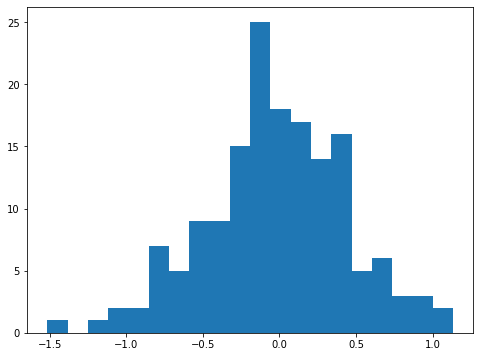

In [36]:
plt.figure(figsize=(8,6))
plt.hist(compare_df["residual"], bins=20)
plt.show()

In [37]:
autorec_rating_df[autorec_rating_df["rating"].isna()].sort_values(by="autorec_rating", ascending=False).head(10)

,userId,movieId,autorec_rating,rating
34,20,34,3.798368,NaN
83,20,83,3.722512,NaN
82,20,82,3.694973,NaN
109,20,109,3.691950,NaN
177,20,177,3.691036,NaN
102,20,102,3.632533,NaN
87,20,87,3.622662,NaN
183,20,183,3.594635,NaN
78,20,78,3.589635,NaN
129,20,129,3.577334,NaN
